<a href="https://colab.research.google.com/github/Chahatchopra/AI-based-Weather-Forecasting/blob/main/WeatherForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries


In [ ]:
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import display
import seaborn as sns

In [ ]:
!pip install graphviz==0.20.1

In [ ]:
API_KEY="3839bc4bb352e6f2f06e4fcd6697555f"
BASE_URL="https://api.openweathermap.org/data/2.5/"

In [ ]:
def get_current_weather(city):
  url = f"{BASE_URL}weather?q={city}&appid={API_KEY}&units=metric"
  response = requests.get(url)
  data = response.json()
  return {
  'city': data['name'],
  'current_temp': round(data['main']['temp']),
  'feels_like': round(data['main']['feels_like']),
  'temp_min': round(data['main']['temp_min']),
  'temp_max': round(data['main']['temp_max']),
  'humidity': round(data['main']['humidity']),
  'description': data['weather'][0]['description'],
  'country': data['sys']['country'],
  'wind_gust_dir': data['wind']['deg'],
  'Wind_Gust_Speed' : data['wind']['speed'],
  'pressure': data['main']['pressure'],
  'visibility': data['visibility'],
  }


Historical Data

In [ ]:
def read_historical_data(filename):
  df = pd.read_csv(filename)
  df = df.dropna()
  df = df.drop_duplicates()
  return df

Visualizing the Data

   MinTemp  MaxTemp WindGustDir  WindGustSpeed  Humidity  Pressure  Temp  \
0      8.0     24.3          NW           30.0        29    1015.0  23.6   
1     14.0     26.9         ENE           39.0        36    1008.4  25.7   
2     13.7     23.4          NW           85.0        69    1007.2  20.2   
3     13.3     15.5          NW           54.0        56    1007.0  14.1   
4      7.6     16.1         SSE           50.0        49    1018.5  15.4   

  RainTomorrow  
0          Yes  
1          Yes  
2          Yes  
3          Yes  
4           No  
     MinTemp  MaxTemp WindGustDir  WindGustSpeed  Humidity  Pressure  Temp  \
361      9.0     30.7         NNW           76.0        15    1010.8  30.0   
362      7.1     28.4           N           48.0        22    1016.9  28.2   
363     12.5     19.9         ESE           43.0        47    1022.8  18.3   
364     12.5     26.9          NW           46.0        39    1016.2  25.9   
365     12.3     30.2          NW           78.0   

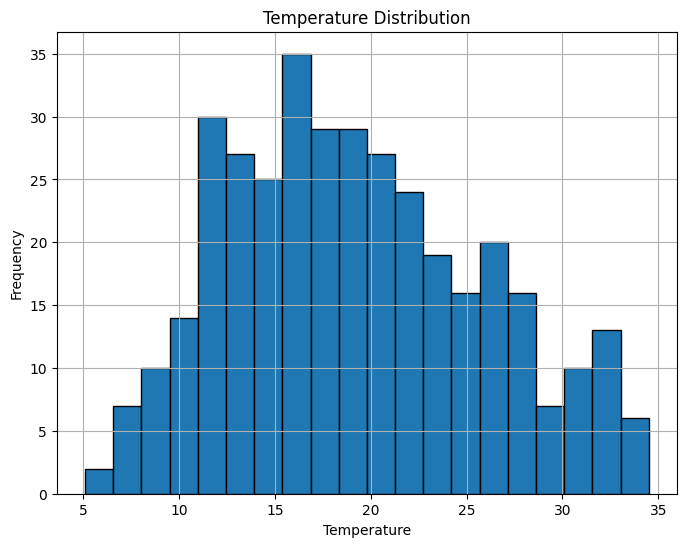

In [ ]:
df = pd.read_csv('/content/weatherdataset.csv')
print(df.head())
print(df.tail())

plt.figure(figsize=(8, 6))
plt.hist(df['Temp'], bins=20, edgecolor='black')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Distribution')
plt.grid(True)
plt.show()

Data Training

In [ ]:
def prepare_data(data):
  le = LabelEncoder()
  data["WindGustDir"]=le.fit_transform(data["WindGustDir"])
  data["RainTomorrow"]=le.fit_transform(data["RainTomorrow"])

  X= data[["MinTemp",'MaxTemp','WindGustDir','WindGustSpeed','Humidity','Pressure','Temp']]
  y = data['RainTomorrow']
  return X, y, le

Training Model

In [ ]:
def train_rain_model(x, y):
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
  model = RandomForestClassifier(n_estimators=100, random_state=42)
  n_splits = 5
  kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
  train_losses = []
  val_losses = []
  for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
      X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
      y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
      model.fit(X_train_fold, y_train_fold)
      y_train_pred = model.predict_proba(X_train_fold)
      train_loss = log_loss(y_train_fold, y_train_pred)
      train_losses.append(train_loss)
      y_val_pred = model.predict_proba(X_val_fold)
      val_loss = log_loss(y_val_fold, y_val_pred)
      val_losses.append(val_loss)
  plt.plot(train_losses, label='Training Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.xlabel('Fold')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.show()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print("Mean Squared Error for Rain model")
  print(mean_squared_error(y_test, y_pred))
  accuracy = accuracy_score(y_test, y_pred)
  cm = confusion_matrix(y_test, y_pred)
  print("Confusion Matrix:")
  print(cm)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Rain', 'Rain'])
  disp.plot()
  plt.show()
  print("Accuracy:")
  print(accuracy)
  return model

Prepare Regression Data

In [ ]:
# Learning relationship between past and future values
def prepare_regression_data(data, feature) :
  X,y=[],[]
  for i in range(len(data)-1):
    X.append(data[feature].iloc[i])
    y.append(data[feature].iloc[i+1])
  X=np.array(X).reshape(-1, 1)
  y=np.array(y)
  return X,y

Train Regression Model

In [ ]:
def train_regression_model(X, y):
  model = RandomForestRegressor(n_estimators=100, random_state=42)
  model.fit(X, y)
  return model

In [ ]:
def predict_future(model, current_value) :
  predictions = [current_value]
  for i in range(5):
    next_value = model.predict(np.array([[predictions[-1]]]))
    predictions.append(next_value[0])
  return predictions[1:]

Weather Analysis

Enter any city name: Dubai


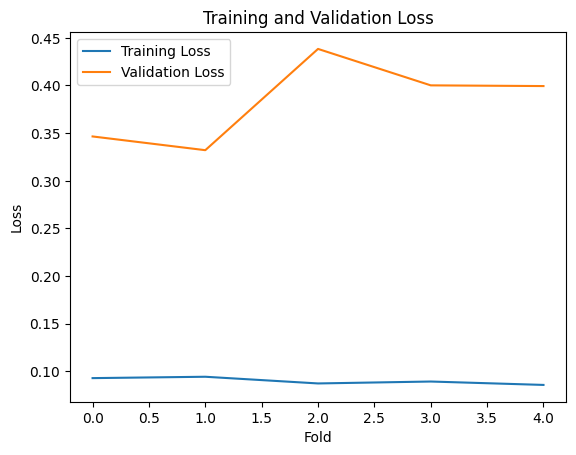

Mean Squared Error for Rain model
0.1506849315068493
Confusion Matrix:
[[56  1]
 [10  6]]


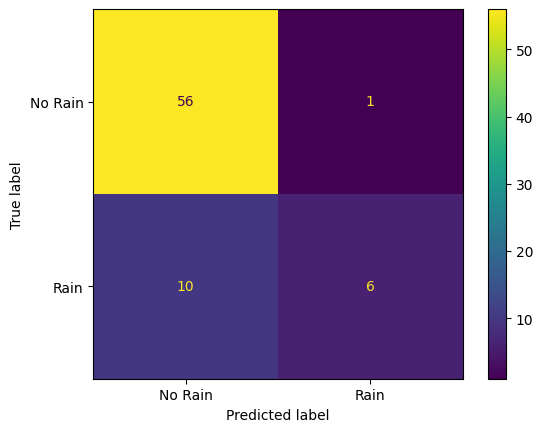

Accuracy:
0.8493150684931506
City: Dubai, AE
Current Temperature: 24
Feels Like: 23
Minimum Temperature: 18°C
Maximum Temperature: 24°C
Humidity: 38%
Weather Prediction: clear sky
Rain prediction: No

Future Temperature Predictions: 
00:00: 20.6°C
01:00: 21.3°C
02:00: 20.5°C
03:00: 22.2°C
04:00: 22.7°C

Future Humidity Predictions: 
00:00: 52.3%
01:00: 43.4%
02:00: 46.8%
03:00: 47.2%
04:00: 47.2%


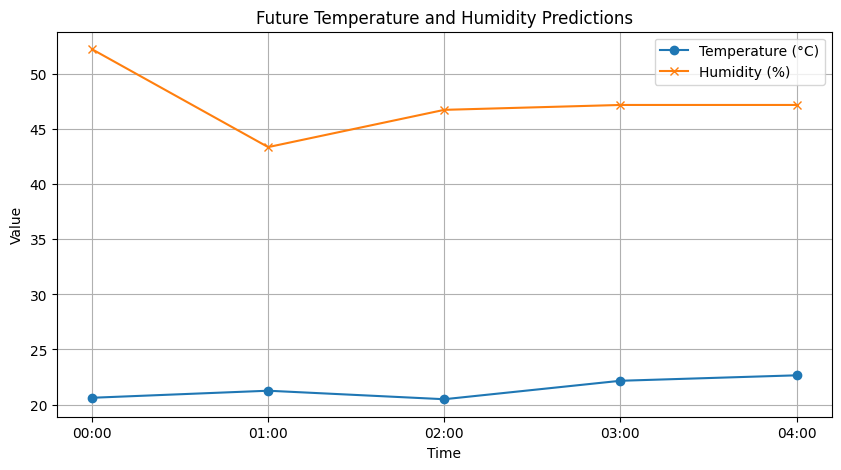

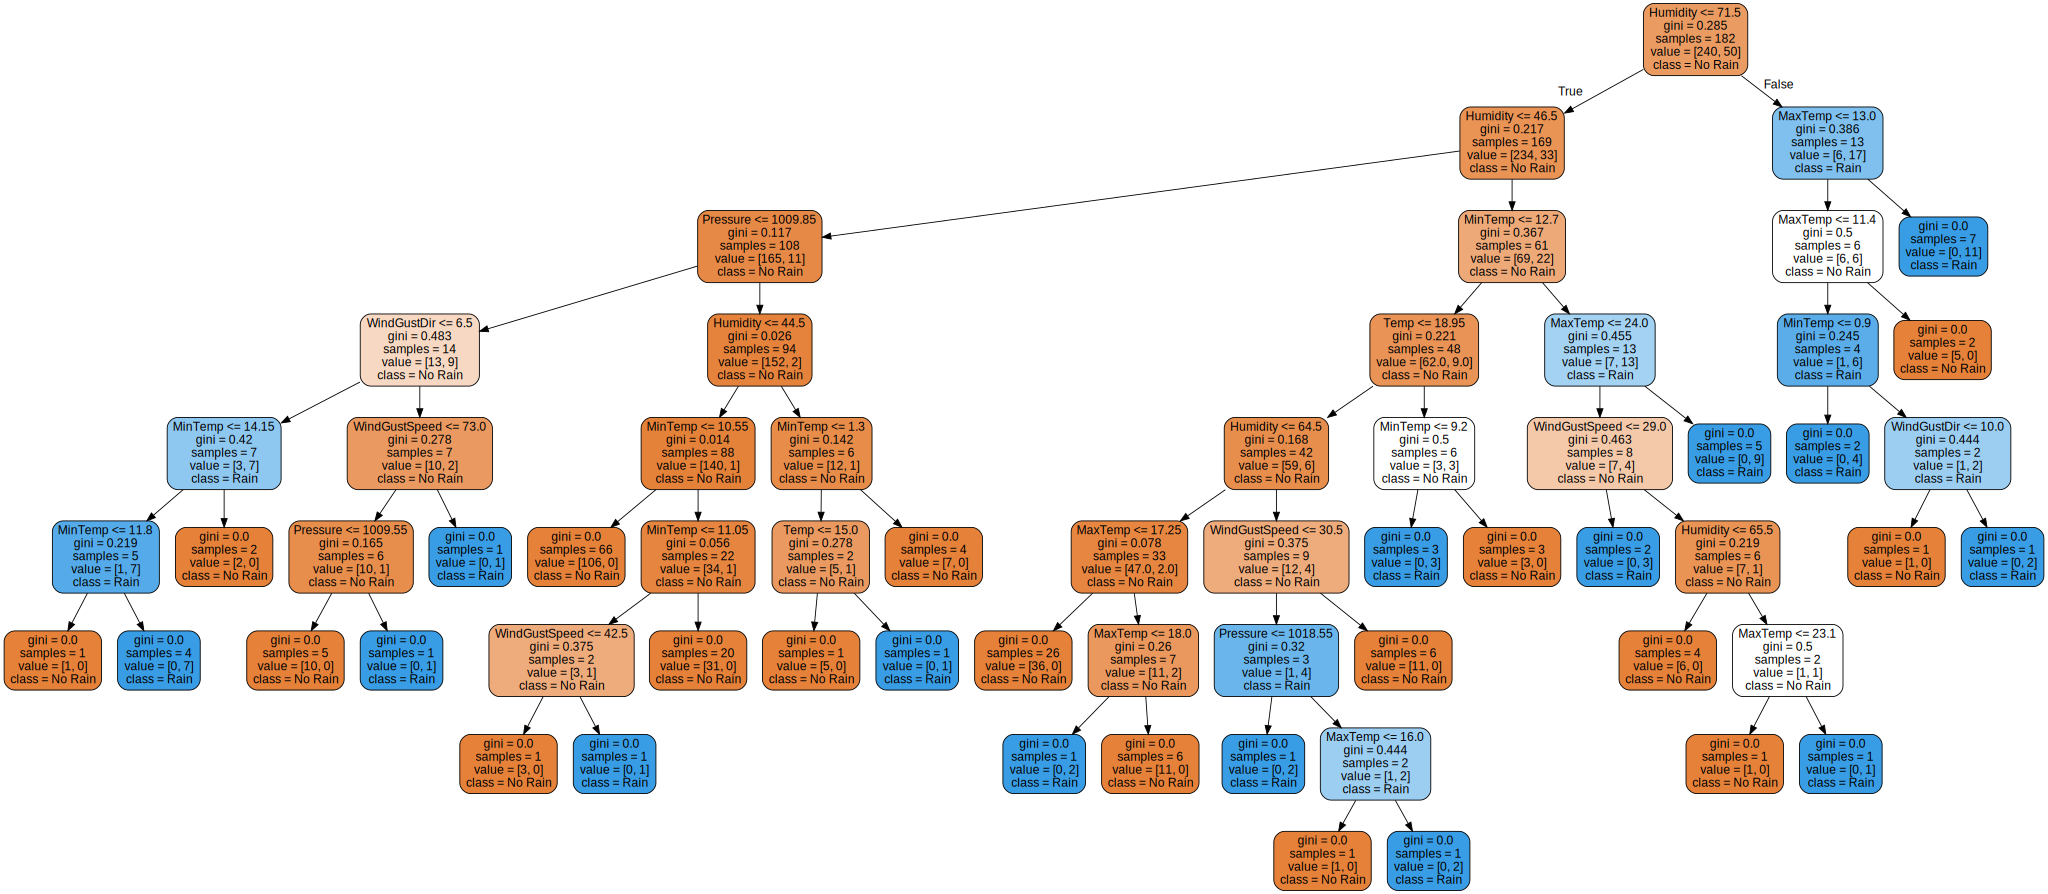

In [ ]:
def weather_view():
  city = input('Enter any city name: ')
  current_weather = get_current_weather(city)
  historical_data = read_historical_data('/content/weatherdataset.csv')
  X, y, le = prepare_data(historical_data)
  rain_model = train_rain_model(X, y)

  wind_deg=current_weather[ 'wind_gust_dir'] % 360
  compass_points={
      ('N',0, 11.25), ('NNE',11.25, 33.75),("NE", 33.75, 56.25),
      ('ENE',56.25, 78.75), ('E',78.75, 101.25),("ESE", 101.25, 123.75),
      ('SE',123.75, 146.25), ('SSE',146.25, 168.75),("S", 168.75, 191.25),
      ('SSW',191.25, 213.75), ('SW',213.75, 236.25),("WSW", 236.25, 258.75),
      ('W',258.75, 281.25), ('WNW',281.25, 303.75),("NW", 303.75, 326.25),
      ('NNW',326.25, 348.75),
  }
  compass_direction=next(point for point, start, end in compass_points if start <= wind_deg < end)
  compass_direction_encoded=le.transform([compass_direction])[0] if compass_direction in le.classes_ else -1


  current_data ={
      'MinTemp': current_weather['temp_min'],
      'MaxTemp': current_weather['temp_max'],
      'WindGustDir': compass_direction_encoded,
      'WindGustSpeed': current_weather['Wind_Gust_Speed'],
      'Humidity': current_weather['humidity'],
      'Pressure': current_weather['pressure'],
      'Temp': current_weather['current_temp']
  }

  current_df= pd.DataFrame([current_data])
  # current_X=current_df[['MinTemp','MaxTemp','WindGustDir','WindGustSpeed','Humidity','Pressure','Temp']]

  rain_prediction= rain_model.predict(current_df)[0]
  X_temp, y_temp = prepare_regression_data(historical_data, "Temp")
  X_hum, y_hum = prepare_regression_data(historical_data, 'Humidity')
  temp_model = train_regression_model(X_temp, y_temp)
  hum_model = train_regression_model(X_hum, y_hum)

  future_temp = predict_future(temp_model, current_weather['temp_min'])
  future_humidity = predict_future(hum_model, current_weather['humidity'])

  timezone = pytz.timezone('Asia/Karachi')
  now = datetime.now(timezone)
  next_hour = now + timedelta(hours=1)
  next_hour= next_hour.replace(minute=0, second=0, microsecond=0)
  future_times = [(next_hour + timedelta(hours=i)).strftime("%H:00") for i in range(5)]

  print(f"City: {city}, {current_weather['country']}")
  print(f"Current Temperature: {current_weather['current_temp']}")
  print(f"Feels Like: {current_weather['feels_like']}")
  print(f"Minimum Temperature: {current_weather['temp_min']}°C")
  print(f"Maximum Temperature: {current_weather['temp_max']}°C")
  print(f"Humidity: {current_weather['humidity']}%")
  print(f"Weather Prediction: {current_weather['description']}")
  print(f"Rain prediction: {'Yes' if rain_prediction else 'No'}")

  print("\nFuture Temperature Predictions: ")

  for time, temp in zip(future_times, future_temp) :
    print(f"{time}: {round (temp,1)}°C")
  plt.figure(figsize=(10, 5))
  plt.plot(future_times, future_temp, marker='o', label='Temperature (°C)')

  print("\nFuture Humidity Predictions: ")
  for time, hum in zip(future_times, future_humidity) :
    print(f"{time}: {round(hum,1)}%")
  plt.plot(future_times, future_humidity, marker='x', label='Humidity (%)')

  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.title('Future Temperature and Humidity Predictions')
  plt.legend()
  plt.grid(True)
  plt.show()

  tree = rain_model.estimators_[0]
  dot_data = export_graphviz(tree,
                              feature_names=X.columns,
                              class_names=['No Rain', 'Rain'],
                              filled=True,
                              rounded=True,
                              out_file=None)

  graph = graphviz.Source(dot_data)
  graph.render("rain_tree")
  display(graph)

weather_view()